In [98]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch import autograd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data as Data
from torch.autograd.variable import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

%matplotlib inline

In [99]:
# Parameters
batch_size = 32
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 40

In [111]:
input_images  = np.load('Flowers/flower_imgs.npy')
input_labels = np.load('Flowers/flower_labels.npy')


# Splitting the input data into training and testing data
train_images, test_images, train_labels, test_labels = train_test_split(input_images, input_labels, test_size=0.20)


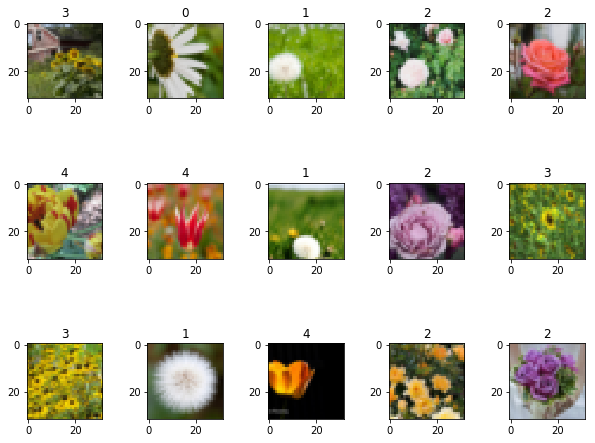

In [112]:
plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.6, hspace=0.4)
# figure
x, y = 5, 3
for i in range(x*y):  
    plt.subplot(y, x, i+1)
    plt.imshow(train_images[i], interpolation='nearest')
    plt.title(train_labels[i])   
plt.show()

In [102]:
# Preprocess the data : Scale these values to a range of 0 to 1
train_images = np.transpose(train_images, (0,3,1,2))
test_images = np.transpose(test_images, (0,3,1,2))
# input_shape = (32, 32, 3)

# Making sure that the values are float so that we can get decimal points after division
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
train_images /= 255
test_images /= 255

#Create a training set
tensor_x = torch.from_numpy(train_images)
tensor_y = torch.from_numpy(train_labels)
train_set = Data.TensorDataset(tensor_x,tensor_y)

#Create a test set
tensor_x = torch.from_numpy(test_images)
tensor_y = torch.from_numpy(test_labels)
test_set = Data.TensorDataset(tensor_x,tensor_y)



In [103]:
# Create a learning rate adjustment function that divides the learning rate by 10 every 30 epochs
def adjust_learning_rate(epoch):
    lr = learning_rate

    if epoch > 180:
        lr = lr / 1000000
    elif epoch > 150:
        lr = lr / 100000
    elif epoch > 40:
        lr = lr / 10000
    elif epoch > 30:
        lr = lr / 1000
    elif epoch > 20:
        lr = lr / 100
    elif epoch > 10:
        lr = lr / 10

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [104]:
class Unit(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unit,self).__init__()
        

        self.conv = nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output

In [105]:
class SimpleNet(nn.Module):
    def __init__(self,num_classes=10):
        super(SimpleNet,self).__init__()

        #Create 14 layers of the unit with max pooling in between
        self.unit1 = Unit(in_channels=3,out_channels=32)
        self.unit2 = Unit(in_channels=32, out_channels=32)
        self.unit3 = Unit(in_channels=32, out_channels=32)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.unit4 = Unit(in_channels=32, out_channels=64)
        self.unit5 = Unit(in_channels=64, out_channels=64)
        self.unit6 = Unit(in_channels=64, out_channels=64)
        self.unit7 = Unit(in_channels=64, out_channels=64)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.unit8 = Unit(in_channels=64, out_channels=128)
        self.unit9 = Unit(in_channels=128, out_channels=128)
        self.unit10 = Unit(in_channels=128, out_channels=128)
        self.unit11 = Unit(in_channels=128, out_channels=128)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.unit12 = Unit(in_channels=128, out_channels=128)
        self.unit13 = Unit(in_channels=128, out_channels=128)
        self.unit14 = Unit(in_channels=128, out_channels=128)

        self.avgpool = nn.AvgPool2d(kernel_size=4)
        
        #Add all the units into the Sequential layer in exact order
        self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.pool1, self.unit4, self.unit5, self.unit6
                                 ,self.unit7, self.pool2, self.unit8, self.unit9, self.unit10, self.unit11, self.pool3,
                                 self.unit12, self.unit13, self.unit14, self.avgpool)

        self.fc = nn.Linear(in_features=128,out_features=num_classes)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,128)
        output = self.fc(output)
        return output

In [106]:
def test():
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):

        # Predict classes using images from the test set
        images = Variable(images)
        labels = Variable(labels)
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        
#         prediction = prediction.data
#         prediction =
        test_acc = (i*test_acc +
                    torch.mean(prediction.eq(labels.data).float()))/(i+1)

    # Compute the average acc and loss over all 10000 test images
#     test_acc = test_acc / 10000

    return test_acc

In [107]:
def train(num_epochs):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('-'*10)
        print("\nEpoch {}/{} \n".format(epoch+1,num_epochs))
        train_acc = 0.0
        train_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            # Move images and labels to gpu if available
            # Clear all accumulated gradients
            model.train()
            optimizer.zero_grad()
            # Predict classes using images from the test set
            images = Variable(images)
            labels = Variable(labels)
            outputs = model(images)
            # Compute the loss based on the predictions and actual labels
            loss = criterion(outputs, labels)
            # Backpropagate the loss
            loss.backward()

            # Adjust parameters according to the computed gradients
            optimizer.step()

            train_loss = (train_loss*i + loss.data[0])/(i+1)
            
            _, prediction = torch.max(outputs.data, 1)
            
            train_acc = (i*train_acc +
                         torch.mean(prediction.eq(labels.data).float()))/(i+1)

        # Call the learning rate adjustment function
        adjust_learning_rate(epoch)

        # Evaluate on the test set
        test_acc = test()

        # Save the model if the test acc is greater than our current best
        if test_acc > best_acc:
#             save_models(epoch)
            best_acc = test_acc
            

        # Print the metrics
        print("Train Accuracy: {}, TrainLoss: {:.4f}, \nTest Accuracy: {}".format(train_acc, train_loss,test_acc))
    print('best_acc = ', best_acc)

In [108]:
# Creating Data Loaders

train_loader = Data.DataLoader(train_set,batch_size = batch_size, shuffle=True)
test_loader= Data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [109]:
model = SimpleNet(num_classes= 5)

optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()


In [110]:
if __name__ == "__main__":
    print("Started Training Network")
    train(num_epochs)
    print("Finished !!")
    

Started Training Network
----------

Epoch 1/40 

best_acc =  0.4263392857142857
Train Accuracy: 0.4690366972477064, TrainLoss: 1.3028 
, Test Accuracy: 0.4263392857142857
----------

Epoch 2/40 

best_acc =  0.5290178571428572
Train Accuracy: 0.5412844036697249, TrainLoss: 1.1404 
, Test Accuracy: 0.5290178571428572
----------

Epoch 3/40 

best_acc =  0.5703124999999999
Train Accuracy: 0.5708142201834864, TrainLoss: 1.0572 
, Test Accuracy: 0.5703124999999999
----------

Epoch 4/40 

Train Accuracy: 0.5974770642201835, TrainLoss: 1.0119 
, Test Accuracy: 0.5267857142857143
----------

Epoch 5/40 

best_acc =  0.5915178571428571
Train Accuracy: 0.6261467889908257, TrainLoss: 0.9448 
, Test Accuracy: 0.5915178571428571
----------

Epoch 6/40 

Train Accuracy: 0.6396215596330275, TrainLoss: 0.9124 
, Test Accuracy: 0.5200892857142858
----------

Epoch 7/40 

best_acc =  0.5926339285714286
Train Accuracy: 0.641915137614679, TrainLoss: 0.8879 
, Test Accuracy: 0.5926339285714286
---------

NameError: name 'Print' is not defined